# Attempt 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm


In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
#normalize the data
x_train = x_train/255
x_test = x_test/255

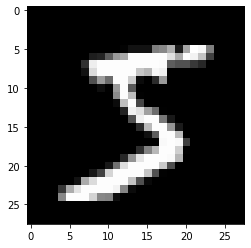

In [ ]:
# select an image from the dataset
selected_image = x_train[0]

# view the image
plt.imshow(selected_image, cmap='gray')
plt.show()

In [ ]:
#reshape the data so it can fit the neural network model
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10) #reshape into categorical data 0 or 1 
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import collections, numpy
train_ans = np.argmax(y_train,axis=1)
collections.Counter(train_ans)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [ ]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [ ]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return(np.maximum(0, x))
    
def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def leaky_relu_derivative(x, alpha=0.01):
    grad = np.zeros_like(x)
    grad[x >= 0] = 1
    grad[x < 0] = alpha
    return grad


def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

def softmax(x):
    x = x - np.max(x, axis = 1).reshape(x.shape[0],1)
    return np.exp(x) / np.sum(np.exp(x), axis = 1).reshape(x.shape[0],1)  

# def softmax_derivative(x):
#     s = np.exp(x) / np.sum(np.exp(x), axis=0)
#     return np.diagflat(s) - np.dot(s[:, None], s[None, :])
# import numpy as np

def softmax_derivative(x):
    sm = softmax(x)
    sm_diag = np.diagflat(x)
    return np.dot(sm_diag, sm_diag.T) - np.outer(x, x)
# def softmax_derivative(z):
#     s = np.exp(z) / np.sum(np.exp(z), axis=0)
#     grad = np.diag(s) - np.dot(s.reshape(-1, 1), s.reshape(1, -1))
#     return grad


In [ ]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, batch, activated_func, activated_func_deriv, last_layer_act, x_train, y_train, x_test,y_test, num_epochs = 10):
        # initialize weights and biases
        self.weights1 = np.random.randn(input_size, hidden_size1)
        self.weights2 = np.random.randn(hidden_size1, hidden_size2)
        self.weights3 = np.random.randn(hidden_size2, output_size)
        self.bias1 = np.random.randn(hidden_size1)
        self.bias2 = np.random.randn(hidden_size2)
        self.bias3 = np.random.randn(output_size)
        self.learning_rate = learning_rate
        self.batch = batch
        self.activated_func = activated_func
        self.activated_func_deriv = activated_func_deriv
        self.last_layer_act = last_layer_act
        self.x = x_train
        self.y = y_train
        self.inputs = x_train[:self.batch] 
        self.outputs = y_train[:self.batch] 
        self.x_test = x_test
        self.y_test = y_test
        self.num_epochs = num_epochs
        self.loss = []
        self.acc = [] 
        

    def shuffle(self):
        idx = [i for i in range(self.x.shape[0])]
        np.random.shuffle(idx)
        self.x = self.x[idx]
        self.y = self.y[idx]          
        
    
    def feedforward(self):
        # feedforward through the first layer
        # print("feedforward weights 1, 2, 3", self.weights1, self.weights2, self.weights3)
        self.z1 = np.dot(self.inputs, self.weights1) + self.bias1
        self.layer1 = self.activated_func(self.z1)
        # feedforward through the second layer
        # print("layer shape", self.layer1.shape)
        self.z2 = np.dot(self.layer1, self.weights2) + self.bias2
        self.layer2 = self.activated_func(self.z2)

        self.z3 = np.dot(self.layer2, self.weights3) + self.bias3
        self.output_bar = self.last_layer_act(self.z3)
        # print("weight2 shape", self.weights2.shape, "bias shape", self.bias2.shape)
        before = np.dot(self.layer2, self.weights3) + self.bias3
        # print("before softmax", before[:10])
        # print("output bar", self.output_bar[:10])
        # print("before", before)
        # print("output_bar", self.output_bar)
        return self.output_bar

    
    def backprop(self):
      
        # calculate the error for the output layer
        # np.sum(self.outputs * np.log(self.output_bar )
        output_error = -np.sum(self.outputs * np.log(self.output_bar + 1e-10)) / self.batch
        output_delta = self.output_bar - self.outputs

        # calculate the error for the second hidden layer
        hidden2_error = np.dot(output_delta, self.weights3.T)
        hidden2_delta = hidden2_error * self.activated_func_deriv(self.layer2)
        
        # calculate the error for the first hidden layer
        hidden1_error = np.dot(hidden2_delta, self.weights2.T)
        hidden1_delta = hidden1_error * self.activated_func_deriv(self.layer1)

        # update the weights and biases
        self.weights3 -= np.dot(self.layer2.T, output_delta) * self.learning_rate
        self.weights2 -= np.dot(self.layer1.T, hidden2_delta) * self.learning_rate
        self.weights1 -= np.dot(self.inputs.T, hidden1_delta) * self.learning_rate
        self.bias3 -= np.sum(output_delta) * self.learning_rate
        self.bias2 -= np.sum(hidden2_delta) * self.learning_rate
        self.bias1 -= np.sum(hidden1_delta) * self.learning_rate


    def cross_entropy_loss(self):
        
        loss = -np.sum(self.outputs * np.log(self.output_bar + 1e-10)) / self.batch
        return loss    
    
    def loss_cal(self): 
        # self.loss.append(l/(self.input.shape[0]//self.batch))
        return np.mean(np.square(self.outputs - self.output_bar))

    def train(self):
        """
        Train the neural network using the given inputs and outputs
        inputs: array of inputs of shape (number of inputs, number of examples)
        outputs: array of outputs of shape (number of outputs, number of examples)
        learning_rate: float, the learning rate to use for the update
        num_epochs: int, the number of times to train the network on the entire dataset
        """
        predict = []
        real = []
        # print("start training")
        for epoch in tqdm(range(self.num_epochs)):
            loss = 0
            acc_count = 0
            # self.shuffle()
            # print("epoch 1")
            # print("self.x.shape[0]=", self.x.shape[0])
            # print("self.batch=", self.batch)
            # print("self.x.shape[0]//self.batch-1= ", self.x.shape[0]//self.batch-1)
            for batch in range(self.x.shape[0]//self.batch):
                # print("batch 1")
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.inputs = self.x[start:end]
                self.ouputs = self.y[start:end]
                self.feedforward()
                self.backprop()
                loss += self.cross_entropy_loss()
                # print("my ouput", self.output_bar[:10])
                predict.append(np.argmax(self.output_bar,axis=1))
                real.append(np.argmax(self.outputs,axis=1)) 
                # print("correct output", self.outputs[:10])
                # print(np.argmax(self.output_bar,axis=1), np.argmax(self.outputs,axis=1))
                acc_count += np.count_nonzero(np.argmax(self.output_bar,axis=1) == np.argmax(self.outputs,axis=1))
            self.loss.append(loss/(self.x.shape[0]))
            self.acc.append(acc_count*100/(self.x.shape[0]))

        return predict, real
    
    def loss_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_cal(self):        
        # print("choose bucket", np.argmax(self.output_bar,axis=1)[:10])
        # print("output", self.outputs[:3])
        # print("right bucket", np.argmax(self.outputs,axis=1)[:10])
        acc_count = np.count_nonzero(np.argmax(self.output_bar,axis=1) == np.argmax(self.outputs,axis=1))
        acc = int(acc_count)/self.outputs.shape[0] * 100
        return acc
    
    def accuracy_plot(self): 
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")        

    def test(self): 
        self.inputs = self.x_test
        self.outputs = self.y_test
        self.feedforward()
        acc = np.count_nonzero(np.argmax(self.output_bar,axis=1) == np.argmax(self.outputs,axis=1)) / self.inputs.shape[0]
        print("Accuracy:", 100 * acc, "%")        
        predict = np.argmax(self.output_bar,axis=1) 
        real = np.argmax(self.outputs,axis=1)
        return predict, real

Code notes: 
```np.random.randn```: Randomly initialize weights and bias following a normal distribution with mean =0, std = 1

## Test case 1: Select only the samples with label 1

In [ ]:
# #Select only the samples with label 1
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 1]
y_train = y_train[y_train == 1]
x_test = x_test[y_test == 1]
y_test = y_test[y_test == 1]

x_train = x_train/255
x_test = x_test/255
#reshape the data so it can fit the neural network model
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10) #reshape into categorical data 0 or 1 
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6742, 784) (6742, 10)
(1135, 784) (1135, 10)


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


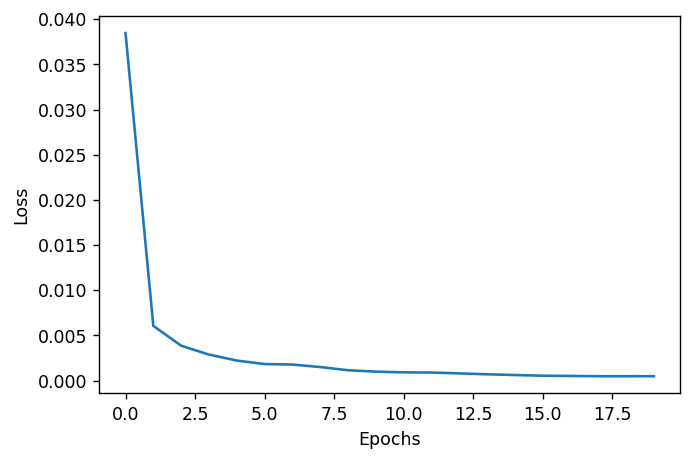

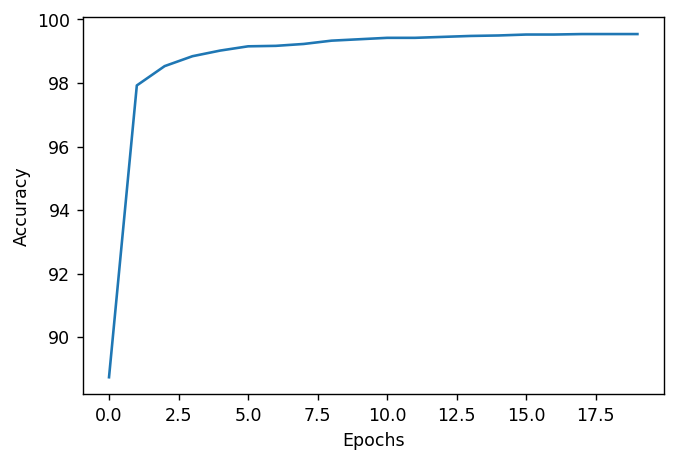

In [ ]:
nn = NeuralNetwork(784, 256, 128, 10, 0.00001, 64, relu, relu_derivative, softmax, x_train, y_train, x_test, y_test, 20)
predict, real = nn.train()
nn.loss_plot()
nn.accuracy_plot()

## Test 2: test with 2 labels 1 and 9

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[numpy.logical_or(y_train == 1, y_train == 9)]
y_train = y_train[numpy.logical_or(y_train == 1, y_train == 9)]

x_test = x_test[numpy.logical_or(y_test == 1, y_test == 9)]
y_test = y_test[numpy.logical_or(y_test == 1, y_test == 9)]

x_train = x_train/255
x_test = x_test/255
#reshape the data so it can fit the neural network model
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10) #reshape into categorical data 0 or 1 
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12691, 784) (12691, 10)
(2144, 784) (2144, 10)


100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


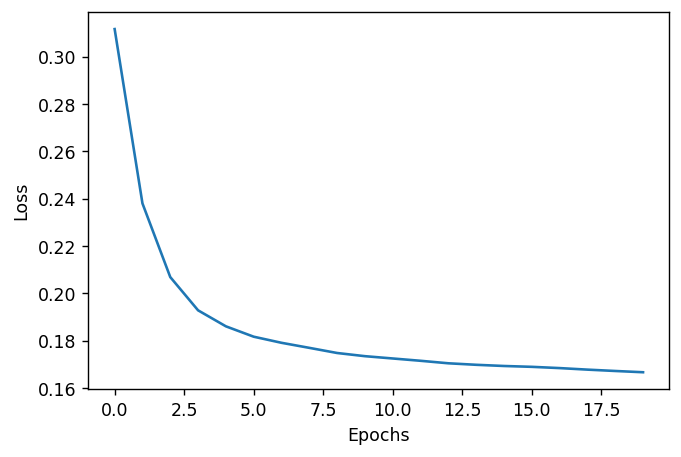

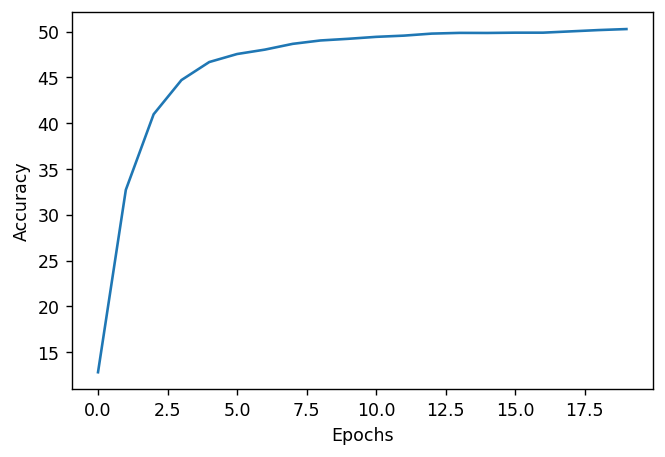

In [ ]:
#input_size, hidden_size1, hidden_size2, output_size, learning_rate, batch, x, y):
nn = NeuralNetwork(784, 256, 128, 10, 1e-6, 64, relu, relu_derivative, softmax, x_train, y_train, x_test, y_test,  20)
predict, real = nn.train()
nn.loss_plot()
nn.accuracy_plot()

In [ ]:
predict, real = nn.test()

Accuracy: 50.373134328358205 %


## The dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train/255
x_test = x_test/255
#reshape the data so it can fit the neural network model
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10) #reshape into categorical data 0 or 1 
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


100%|██████████| 30/30 [02:33<00:00,  5.11s/it]


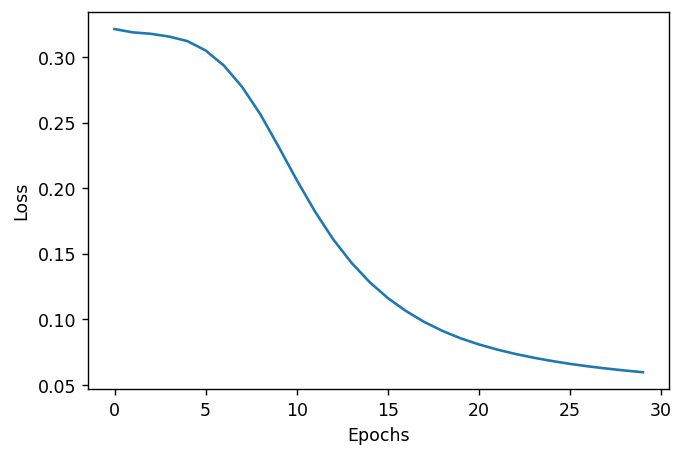

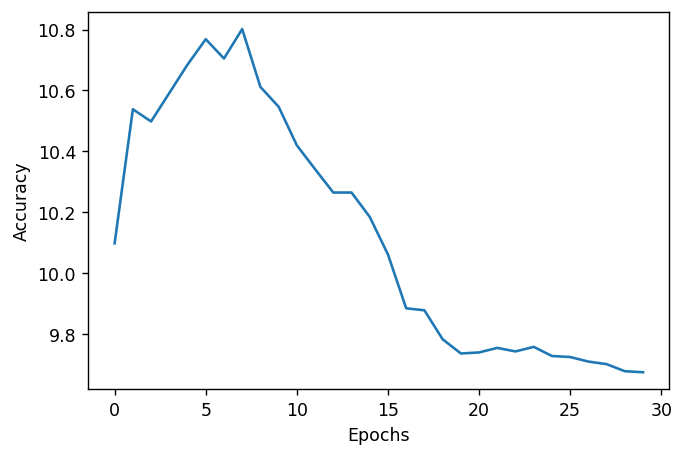

In [ ]:
#input_size, hidden_size1, hidden_size2, output_size, learning_rate, batch, x, y):
nn = NeuralNetwork(784, 256, 128, 10, 1e-6, 64, relu, relu_derivative, softmax, x_train, y_train, x_test, y_test, num_epochs = 30)
predict, real = nn.train()
nn.loss_plot()
nn.accuracy_plot()

In [ ]:
predict, real = nn.test()

Accuracy: 9.120000000000001 %


## Problem 
It seems that my result has similar performance to random guess. 

## Learning 

Observation 1: It performs so bad when I choose 50 hidden neurons, but improve so much better when I choose 256.

- How to choose the right number for the neurons in the hidden layer? 
- Increasing the number of neurons can increase the capacity of the network and make it more capable of learning complex patterns in the data. However, having too many neurons can lead to overfitting, where the network becomes too specialized to the training data and is unable to generalize well to new data.
- Reason of choosing the factorial of 2: Easier computation. 
- Resources: [My Neural Network isn't working! What should I do?
](https://theorangeduck.com/page/neural-network-not-working)

Observation 2: Creating batches significantly improve my accuracy. 


Observation 3: Learning Rate matters sooooooo much!

Since I am not able to figure out the error, I consult 
[external resource](https://medium.com/analytics-vidhya/neural-network-mnist-classifier-from-scratch-using-numpy-library-94bbcfed7eae) and modify the code. I would appreciate suggestions to fix my code.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Deep Learning/Assignment1.ipynb" ./
!jupyter nbconvert --to pdf 'Assignment1.ipynb'

[NbConvertApp] Converting notebook Assignment1.ipynb to pdf
[NbConvertApp] Support files will be in Assignment1_files/
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Making directory ./Assignment1_files
[NbConvertApp] Writing 64282 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 165669 bytes to Assignment1.pdf
